## A. Requirements

#### Check readme you have to install chrome webdriver

In [1]:
!pip -q install selenium
import selenium


### (2) Install Some Python Packages

In [2]:
!pip install -q bs4 jupyter_contrib_nbextensions pillow splinter
!jupyter nbextension enable python-markdown/main

Enabling notebook extension python-markdown/main...
      - Validating: problems found:
        - require?  X python-markdown/main


In [3]:
from splinter import Browser
import base64, getpass, json, os, re, requests, sys, time
from bs4 import BeautifulSoup

## B. Definitions

### B. 1 Some constants

In [4]:
# WARNING:
# this will impact your user experience!
# adjust loading time according to your network speed!
# loading time in seconds

loading_time = 5


In [5]:
homepage='https://www.coursera.org'

In [6]:
# VIDEO RESOLUTION
resolution = {'low':'360','med':'540','hi':'720'}

# available resolution:
# 'hi', 'low' or 'med'
# choose according to your preference
chosen_res = 'hi'

In [7]:
initial_dirname = os.getcwd()

### B.2 Helper Functions

In [8]:
def screenshot():
    browser.driver.save_screenshot('screenshot.png')
    from PIL import Image
    return Image.open('screenshot.png')

In [9]:
def encode_cjson(text):
    return base64.b64encode(bytes(str(text), "utf-8"))

def save_cjson(text):
    text = encode_cjson(text)
    with open('coursera.json','wb+') as f:
        f.write(bytes(str(text),"utf-8"))
    f.close()

def read_cjson():
    
    if os.path.isfile('coursera.json'):
        with open('coursera.json','rb') as f:
            a = f.read()
        f.close()
    else:
        print('credential file not found')
    return str(a).split("'")[1]

def decode_cjson(text):
    return str(base64.b64decode(text)).split("'")[1]

def get_cjson():

    text = read_cjson()
    
    uid = json.loads(decode_cjson(text))
    return uid

def remove_cjson():
    
    if os.path.isfile('coursera.json'):
        os.remove('coursera.json')

def get_credential():

    if os.path.isfile('coursera.json'):
        username = get_cjson()['user']
        password = get_cjson()['password']
    else:
        username = input('User Name:')
        password = getpass.getpass('Password:')
        text = '{"user":"'+username+'", "password":"'+password+'"}'
        save_cjson(text)
        
    return username, password

def remove_credential():
    remove_cjson()
    print('credential removed...')
    return

def reset_credential():
    remove_cjson()
    username, password = get_credential()
    return username, password

In [10]:
def read_text_file(file_name):
    f = open(file_name, "r")
    print("file being read: " + file_name + "\n")  
    return f.read()

def file_create(file_name, str_data):
    try:  
        f = open(file_name, "w")
        f.writelines(str(str_data))
        f.close()
    except IOError:        
        file_name = file_name.split(os.sep)[-1]
        f = open(file_name, "w")
        f.writelines(str(str_data))
        f.close()
    print("file created: " + file_name + "\n")
    
def convert_content(file_contents):
    replacement = re.sub(r'([\d]+)\.([\d]+)', r'\1,\2', file_contents)
    replacement = re.sub(r'WEBVTT\n\n', '', replacement)
    replacement = re.sub(r'^\d+\n', '', replacement)
    replacement = re.sub(r'\n\d+\n', '\n', replacement)
    return replacement

def vtt_to_srt(file_name):
    
    file_contents = read_text_file(file_name)
    str_data = ""
    str_data = str_data + convert_content(file_contents)  
    file_name = file_name.replace(".vtt",".srt")
    print(file_name)
    file_create(file_name, str_data)

In [11]:
def get_mp4_url(lesson_url):
    
    if lesson_url not in browser.driver.current_url:
        browser.visit(homepage+lesson_url)
        time.sleep(loading_time)
        print('video playing will be paused in ' + str(loading_time) + ' seconds...')
        time.sleep(loading_time)
    try:
        browser.find_by_css('span.cif-2x.cif-fw.cif-pause').click()
    except:
        time.sleep(loading_time)
        try:
            browser.find_by_css('span.cif-2x.cif-fw.cif-pause').click()
        except:
            pass
        pass
    mp4 = browser.find_by_tag('video').find_by_tag('source')['src']
    mp4 = mp4.replace('360p/',resolution[chosen_res]+'p/')
    return mp4

def get_vtt_url(lesson_url):
    if lesson_url not in browser.driver.current_url:
        browser.visit(homepage+lesson_url)
        time.sleep(loading_time)
    element = browser.find_by_css('li.rc-SubtitleDownloadItem.resource-list-item')
    vtt = BeautifulSoup(element.html, 'lxml').findAll('a')[0]['href']
    vtt = homepage + vtt
    return vtt

In [12]:
def vtt_downloader(lesson_id, lesson_title, lesson_url):
    
    base_filename = lesson_id +'-'+ safe_text(lesson_title)    
    file_name = base_filename + '.vtt'
    file_exists = os.path.isfile(file_name)

    if file_exists:
        print('subtitle already downloaded.')
    else:
        vtt = get_vtt_url(lesson_url)
        r = requests.get(vtt)
        f = open(file_name, 'w')
        f.write(r.text)
        f.close()
    vtt_to_srt(file_name)
        
def mp4_downloader(lesson_id, lesson_title, lesson_url):
    
    mp4 = get_mp4_url(lesson_url)
    base_filename = lesson_id +'-'+ safe_text(lesson_title)
    file_name = base_filename + '.mp4'

    downloaded_size = 0
    buffer_size = 1024

    print('requesting to download...')
    r = requests.get(mp4)
    content_length = r.headers['Content-Length']
    download_size = int(content_length)
    file_exists = os.path.isfile(file_name)
    
    if file_exists:
        
        if os.path.getsize(file_name) == download_size:
            print('mp4 already downloaded.')
            
    elif not file_exists:
        
        if r.status_code == 200:
            f = open(file_name, 'wb')
            for buffer in r.iter_content(buffer_size):
                f.write(buffer)
                downloaded_size += buffer_size
                status='\rdownloading...' + file_name + '>>> '
                status = status +str("{:.2f}".format(downloaded_size * 100. /download_size))+'%'
                sys.stdout.write(status)
                sys.stdout.flush()
            f.close()
        else:
            print('please check your connection..')

In [13]:
def safe_text(str_text):
    erasable = [':','/']
    for e in erasable:   
        str_text = str_text.replace(e, ' ')  
    while '  ' in str_text:
        str_text = str_text.replace('  ',' ')
    return str_text

In [14]:
def create_download_dir(dirname):
    
    dirname = safe_text(dirname)
    
    try:
        os.mkdir(dirname)
    except:
        pass
    
    os.chdir(dirname)
    print(os.getcwd())

In [15]:
def reformat_html(html, page_title):
    
    html = html.replace('<div class="rc-ItemBox rc-ReadingItem"><div class="item-box-content"><div>',
                  '<div class="rc-ItemBox rc-ReadingItem"><div class="item-box-content"><div> <h2 class="flex-1 align-self-center headline-4-text">'+page_title+'</h2>')

    html = html.replace('<div class="Box_120drhm-o_O-endJustify_b0g9ud-o_O-displayflex_poyjc" style="margin: 60px -60px -60px; border-top: 1px solid rgb(221, 221, 221); padding: 15px;"><div class="rc-ItemFeedback"><div class="rc-ItemFeedbackContent horizontal-box"><div class="rc-Like"><div class="rc-LikeContent"><div><button class="c-button-icon" aria-pressed="false" aria-label="Like"><i class="fa cif-thumbs-o-up" aria-hidden="true"></i></button></div><span></span></div></div><div class="rc-Dislike"><div class="rc-LikeContent"><div><button class="c-button-icon" aria-pressed="false" aria-label="Dislike"><i class="cif-thumbs-o-down" aria-hidden="true"></i></button></div><span></span></div></div><div class="rc-Flag"><div class="rc-FlagContent"><div><button class="c-button-icon" aria-pressed="false" aria-label="Report problem"><i class="cif-flag-o" aria-hidden="true"></i></button></div><span></span></div></div></div></div></div></div></div>','')
    
    return html

def write_html(base_filename, html):
    
    html = reformat_html(html, base_filename)
    file_name = base_filename + '.html'
    f = open(file_name, 'w')
    html = '<html><head><link href="https://d3njjcbhbojbot.cloudfront.net/webapps/builds/ondemand/app.07c9f4ac0583c6e2d2d1.css" rel="stylesheet"></head><body>'+html+'</body></html>'
    f.write(html)
    f.close()
    
def html_downloader(lesson_id, lesson_title, lesson_url):
    
    if lesson_url not in browser.driver.current_url:
        browser.visit(homepage+lesson_url)
        time.sleep(loading_time)
    try:
        html = browser.find_by_css('div.item-page-content').html
        print('got reading item')
    except:
        html ='no content scraped.'
        pass
    
    base_filename = lesson_id +'-'+ safe_text(lesson_title)
    write_html(base_filename, html)
    
    return

def check_html_reading(lesson_id, lesson_title, lesson_url):
    
    base_filename = lesson_id +'-'+ safe_text(lesson_title)
    file_name = base_filename + '.html'
    
    file_exists = os.path.isfile(file_name)
    if file_exists:
        print('html already downloaded.')
    else:
        html_downloader(lesson_id, lesson_title, lesson_url)

## C. Coursera

### Login Page

In [16]:
browser = Browser('chrome', headless = True)

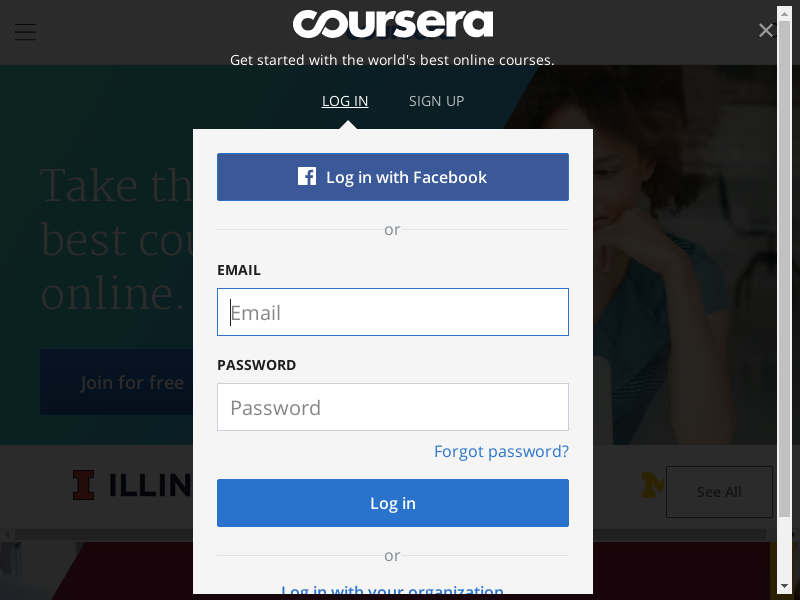

In [17]:
browser.visit('https://www.coursera.org/?authMode=login')
screenshot()

### Insert Login Credential

In [18]:
#reset_credential() #uncomment to reset 
username, password = get_credential()

In [19]:
browser.visit('https://www.coursera.org/courses?authMode=login')

In [20]:
browser.fill('email', username)
browser.fill('password', password)

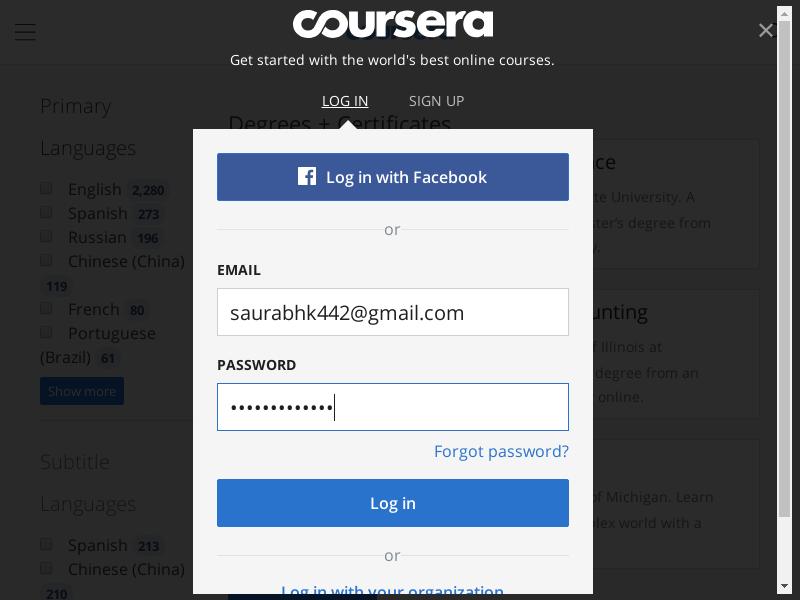

In [21]:
screenshot()

In [22]:
buttons = browser.find_by_tag('button')
for button in buttons:
    if (button.text == 'Log in'):
        button.click()
        break

### LAST ACTIVE COURSES

/home/saurabh/Documents/deep-neural-network


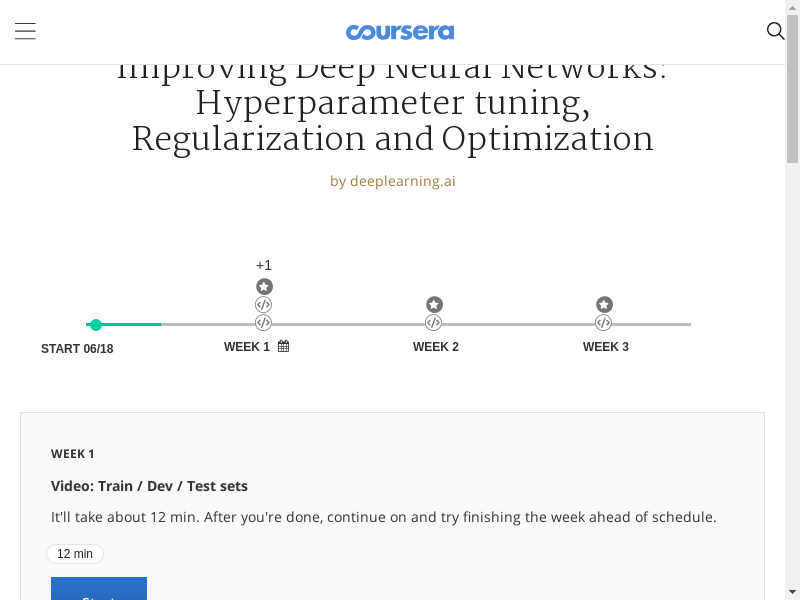

In [23]:
# give name of where you want to download
course_title="deep-neural-network"
# give the link of course in which you are enrolled and you want to download
course_link="https://www.coursera.org/learn/deep-neural-network/home/welcome"
lecture_homepage = browser.driver.current_url
browser.visit(course_link)

create_download_dir(course_title)
screenshot()

In [24]:
week = browser.find_by_css('div.rc-WeekCollectionNavigationItem > div')
anchors = BeautifulSoup(week.html, 'lxml').findAll('a', attrs={})
weeks = []
for a in anchors:
    weeks.append(a['href'])

weeks, len(weeks)

(['/learn/deep-neural-network/home/week/1',
  '/learn/deep-neural-network/home/week/2',
  '/learn/deep-neural-network/home/week/3'],
 3)

In [25]:
lessons_i = []
lessons_t = []
lessons_u = []
    
for w in range(len(weeks)):
    
    print('collecting lessons title and urls...\n')    
    browser.visit(homepage + weeks[w])
    time.sleep(loading_time)
    w = w+1
    
    print('\nVisiting week: ' + str(w))
    time.sleep(loading_time)
    module_lessons = browser.find_by_css('div.rc-ModuleLessons')
    print()
    print('Week '+str(w)+' titles:')
    seq = 0
    for i, module_lesson in enumerate(module_lessons):

        lessons_title = module_lesson.find_by_tag('h5')

        for j, l in enumerate(lessons_title):
            seq  += 1
            lesson_id = str(w*100+seq).zfill(3)
            title = l.text.replace('\n',' ')
            print(lesson_id, title)
            title = safe_text(title)
            lessons_t.append(title)
            lessons_i.append(lesson_id)
    
    print()
    print('Week '+str(w)+' links:')    
    seq = 0

    for i, module_lesson in enumerate(module_lessons):

        lessons_url = module_lesson.find_by_tag('ul')
    
        for j, e in enumerate(lessons_url):
            anchors = BeautifulSoup(e.html, 'lxml').findAll('a')
            for k, a in enumerate(anchors):
                seq += 1
                lesson_id = str(w*100+seq).zfill(3)
                lesson_url = a['href']
                print(lesson_id, lesson_url)
                lessons_u.append(lesson_url)
           
    print()

collecting lessons title and urls...


Visiting week: 1

Week 1 titles:
101 Lecture Train / Dev / Test sets
102 Lecture Bias / Variance
103 Lecture Basic Recipe for Machine Learning
104 Lecture Regularization
105 Lecture Why regularization reduces overfitting?
106 Lecture Dropout Regularization
107 Lecture Understanding Dropout
108 Lecture Other regularization methods
109 Lecture Normalizing inputs
110 Lecture Vanishing / Exploding gradients
111 Lecture Weight Initialization for Deep Networks
112 Lecture Numerical approximation of gradients
113 Lecture Gradient checking
114 Lecture Gradient Checking Implementation Notes
115 Quiz: Practical aspects of deep learning
116 Initialization
117 Programming Assignment: Initialization
118 Regularization
119 Programming Assignment: Regularization
120 Gradient Checking
121 Programming Assignment: Gradient Checking
122 Lecture Yoshua Bengio interview

Week 1 links:
101 /learn/deep-neural-network/lecture/cxG1s/train-dev-test-sets
102 /learn/deep-neu

### Download Lecture Videos and Readings

In [26]:
os.chdir(initial_dirname)
os.chdir(safe_text(course_title))
lessons = zip(lessons_i, lessons_t, lessons_u)
for a,b,c in lessons:
    print(a,b)
    first_word = b.split(' ')[0]
    
    if 'Lecture' in first_word:
        mp4_downloader(a,b,c)
        vtt_downloader(a,b,c)
        print()
        
    elif 'Reading' in first_word:
        check_html_reading(a, b, c)
        print()        
    
    else:
        print('other resource')
        check_html_reading(a,b,c)
        print()
        
    print()
print('Resources downloaded to:\n'+os.getcwd())
os.chdir(initial_dirname)

101 Lecture Train Dev Test sets
video playing will be paused in 5 seconds...
requesting to download...
mp4 already downloaded.
subtitle already downloaded.
file being read: 101-Lecture Train Dev Test sets.vtt

101-Lecture Train Dev Test sets.srt
file created: 101-Lecture Train Dev Test sets.srt



102 Lecture Bias Variance
video playing will be paused in 5 seconds...
requesting to download...
mp4 already downloaded.
subtitle already downloaded.
file being read: 102-Lecture Bias Variance.vtt

102-Lecture Bias Variance.srt
file created: 102-Lecture Bias Variance.srt



103 Lecture Basic Recipe for Machine Learning
video playing will be paused in 5 seconds...
requesting to download...
mp4 already downloaded.
subtitle already downloaded.
file being read: 103-Lecture Basic Recipe for Machine Learning.vtt

103-Lecture Basic Recipe for Machine Learning.srt
file created: 103-Lecture Basic Recipe for Machine Learning.srt



104 Lecture Regularization
video playing will be paused in 5 seconds...

video playing will be paused in 5 seconds...
requesting to download...
mp4 already downloaded.
subtitle already downloaded.
file being read: 209-Lecture Learning rate decay.vtt

209-Lecture Learning rate decay.srt
file created: 209-Lecture Learning rate decay.srt



210 Lecture The problem of local optima
video playing will be paused in 5 seconds...
requesting to download...
mp4 already downloaded.
subtitle already downloaded.
file being read: 210-Lecture The problem of local optima.vtt

210-Lecture The problem of local optima.srt
file created: 210-Lecture The problem of local optima.srt



211 Quiz Optimization algorithms
other resource
html already downloaded.


212 Optimization
other resource
html already downloaded.


213 Programming Assignment Optimization
other resource
html already downloaded.


214 Lecture Yuanqing Lin interview
video playing will be paused in 5 seconds...
requesting to download...
mp4 already downloaded.
subtitle already downloaded.
file being read: 214-Lectur

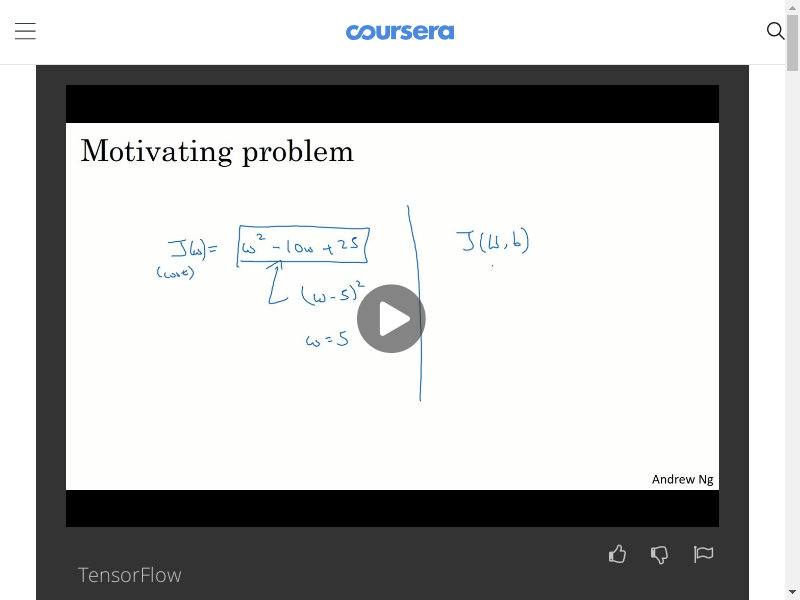

In [27]:
screenshot()

## Screenshot Checking

In case of an error, you may want to check the screenshot. Here is an example:

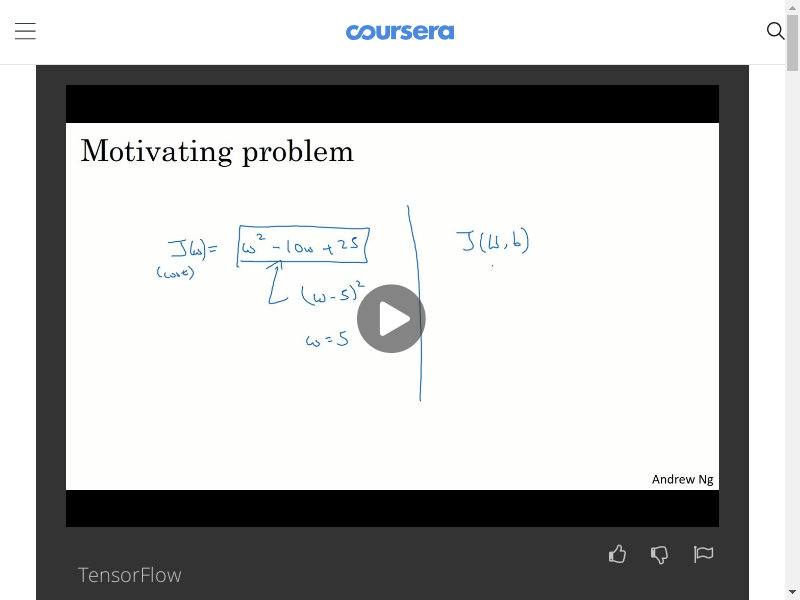

In [28]:
screenshot()

## Manually Calling `mp4_downloader`

In case you need to manually call `mp4_downloader` here is an example:

```
mp4_downloader('201',
               'Lecture Driving Robots Around?', 
               '/learn/mobile-robot/lecture/4HvCW/driving-robots-around')
````
`201` means week `2` lecture `01`

## Close Browser After Download

In [29]:
browser.quit()

In [30]:
os.chdir(initial_dirname)
os.getcwd()

'/home/saurabh/Documents'